In [7]:
using Dates, DataFrames, CSV, JSON, Plots, JuMP, HiGHS, TuLiPa

In [8]:
firm_demand = 50.0
price_elasticity = -0.05
normal_price = 100.0
max_price = 150.0
min_price = 50.0
CapNucGER = 5000.0
GenNucGER = 100.0
threshold = 0.15

gasprice = Float64[1000, 100, 10, 1, 10000, 100000, 1.028, 42]
datetimes = DateTime[getisoyearstart(1981) + Day(i) for i in 1:8]
println(datetimes)
elements = [
    DataElement("Balance", "BaseBalance", "PowerBalance_NO2", Dict{Any, Any}("Commodity" => "Power")),    
    DataElement("Flow", "BaseFlow", "GenNucGER", Dict{Any, Any}()),
    DataElement("Arrow", "BaseArrow", "PowerBalance_NO2", Dict{Any, Any}("Balance" => "PowerBalance_NO2", "Flow" => "GenNucGER", "Conversion" => 1.0, "Direction" => "In")),
    DataElement("Cost", "CostTerm", "MCNucGER", Dict{Any, Any}("Param" => GenNucGER, "WhichInstance" => "GenNucGER", "WhichConcept" => "Flow", "Direction" => "In")),
    DataElement("Capacity", "PositiveCapacity", "CapNucGER", Dict{Any, Any}("Param" => "CapNucGER", "WhichInstance" => "GenNucGER", "WhichConcept" => "Flow", "Bound" => "Upper")),
    DataElement("Param", "MWToGWhSeriesParam", "CapNucGER", Dict{Any, Any}("Level" => CapNucGER, "Profile" => 1.0)),

    DataElement(TIMEINDEX_CONCEPT, "VectorTimeIndex", "IndexProfileGas", Dict("Vector" => datetimes)),
    DataElement(TIMEVALUES_CONCEPT, "VectorTimeValues", "ValuesProfileGas", Dict("Vector" => gasprice)),
    DataElement(TIMEVECTOR_CONCEPT, "RotatingTimeVector", "ProfileGas", Dict(TIMEVALUES_CONCEPT => "ValuesProfileGas", TIMEINDEX_CONCEPT => "IndexProfileGas")),
    DataElement("Param", "MeanSeriesParam", "FirmDemand", Dict{Any, Any}("Level" => 1.0, "Profile" => "ProfileGas")),
    
    DataElement("ElasticDemand", "BaseElasticDemand", "", 
                Dict{Any, Any}("Balance" => "PowerBalance_NO2", "Param" => "FirmDemand",
                "price_elasticity" => price_elasticity, 
                "normal_price" => normal_price , 
                "max_price" => max_price, 
                "min_price" => min_price,
                "threshold" => threshold
    ))   
        
]

startafter = Millisecond(0)
shrinkatleast = Millisecond(Hour(3*24))
minperiod = Millisecond(Hour(1*24))
subhorizon = SequentialHorizon(5, Day(4))
power_horizon = ShrinkableHorizon(subhorizon, startafter, shrinkatleast, minperiod) #SequentialHorizon(5, Day(1))

push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Power", (HORIZON_CONCEPT, power_horizon)))
addscenariotimeperiod!(elements, "ScenarioTimePeriod", getisoyearstart(1981), getisoyearstart(1983));

[DateTime("1980-12-30T00:00:00"), DateTime("1980-12-31T00:00:00"), DateTime("1981-01-01T00:00:00"), DateTime("1981-01-02T00:00:00"), DateTime("1981-01-03T00:00:00"), DateTime("1981-01-04T00:00:00"), DateTime("1981-01-05T00:00:00"), DateTime("1981-01-06T00:00:00")]


In [9]:
modelobjects = getmodelobjects(elements)
mymodel = JuMP.Model(HiGHS.Optimizer)
prob = JuMP_Prob(modelobjects, mymodel)

datatime = getisoyearstart(2023)
scenariotime = getisoyearstart(1981)
prob_time = TwoTime(datatime, scenariotime)
update!(prob, prob_time)
solve!(prob)

print(prob.model)

In [10]:
solution_summary(prob.model, verbose = true)

* Solver : HiGHS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "kHighsModelStatusOptimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : -4.44382e+04
  Objective bound    : -4.44382e+04
  Relative gap       : Inf
  Dual objective value : -4.44382e+04
  Primal solution :
    ElasticDemand1[1] : 2.82220e+02
    ElasticDemand1[2] : 4.80000e+02
    ElasticDemand1[3] : 4.11571e+01
    ElasticDemand1[4] : 4.11571e+01
    ElasticDemand1[5] : 4.11571e+01
    ElasticDemand2[1] : 1.99203e+00
    ElasticDemand2[2] : 0.00000e+00
    ElasticDemand2[3] : 2.90504e-01
    ElasticDemand2[4] : 2.90504e-01
    ElasticDemand2[5] : 2.90504e-01
    ElasticDemand3[1] : 1.99203e+00
    ElasticDemand3[2] : 0.00000e+00
    ElasticDemand3[3] : 2.90504e-01
    ElasticDemand3[4] : 2.90504e-01
    ElasticDemand3[5] : 2.90504e-01
    ElasticDemand4[1] : 3.98405e+00
    ElasticDemand4

5
MsTimeDelta(Millisecond(345600000))
288.0
27500.507
42.0
42.0
42.0

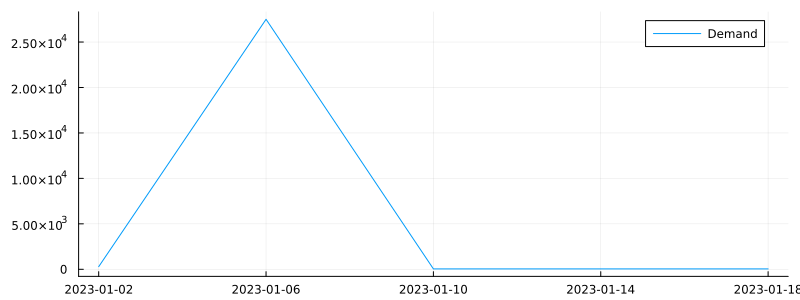

In [11]:
elastic_object = modelobjects[Id("ElasticDemand", "")].firm_demand
i = []
demand = []
println(getnumperiods(power_horizon))
println(gettimedelta(power_horizon, 1))
querydelta = gettimedelta(power_horizon, 1)# 1
for t in 1:getnumperiods(power_horizon)
    querystart = getstarttime(power_horizon, t, prob_time)
    push!(i, getdatatime(querystart))
    d = getparamvalue(elastic_object, querystart, querydelta)
    println(d)
    push!(demand, d)
end
plot(i, demand, lw = 1, label = "Demand", size=(800,300))

In [12]:
ed = modelobjects[Id("ElasticDemand", "")]

for i in 1:getnumperiods(power_horizon)
    println(getdemand(prob, ed, i))
end

290.1881936381667
480.0
42.31911157223264
42.31911157223264
42.31911157223264
